<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/2024_Revnb_75_25_Update_H1_T1_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00


In [9]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [10]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

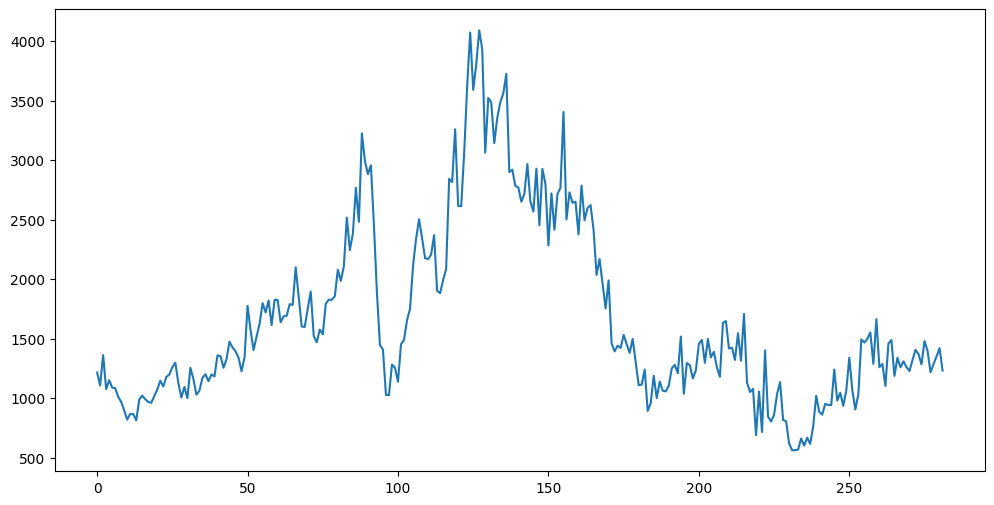

In [11]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Peramalan-LSTM_75-25/main/Ekspor-Migas-2001-2024.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [12]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [13]:
time_steps = 1
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [14]:
ytest = test
ytrain = train

In [15]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [16]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (210, 1, 1)
y_train.shape:  (210, 1)
X_test.shape:  (71, 1, 1)
y_test.shape:  (71, 1)


In [18]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [20]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [21]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 09:45:41,295] A new study created in memory with name: no-name-6cb55ab7-c8c0-4154-873e-76ba98435b8c


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 1: MSE = 0.0470
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.1502


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Fold 3: MSE = 0.4231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.2192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-13 09:46:08,199] Trial 0 finished with value: 0.17060168087482452 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.17060168087482452.


Fold 5: MSE = 0.0134
Average MSE: 0.1706
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0279
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0801
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.2568
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0468
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


[I 2024-08-13 09:46:28,342] Trial 1 finished with value: 0.08880545943975449 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.08880545943975449.


Fold 5: MSE = 0.0324
Average MSE: 0.0888
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0516
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Fold 3: MSE = 0.2155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0322
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 09:46:45,705] Trial 2 finished with value: 0.07239164412021637 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.07239164412021637.


Fold 5: MSE = 0.0379
Average MSE: 0.0724
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0815
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Fold 2: MSE = 0.1593
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.4332
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.2373
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 09:47:02,382] Trial 3 finished with value: 0.18489819765090942 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.07239164412021637.


Fold 5: MSE = 0.0131
Average MSE: 0.1849
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 1: MSE = 0.0397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0813
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.1985
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0538
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


[I 2024-08-13 09:47:18,541] Trial 4 finished with value: 0.08066170662641525 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.07239164412021637.


Fold 5: MSE = 0.0301
Average MSE: 0.0807
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0459
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.1948
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 4: MSE = 0.0353
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 09:47:35,140] Trial 5 finished with value: 0.0668410062789917 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.0668410062789917.


Fold 5: MSE = 0.0332
Average MSE: 0.0668
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 1: MSE = 0.0218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-13 09:47:54,268] Trial 6 finished with value: 0.012626292183995247 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.012626292183995247.


Fold 5: MSE = 0.0046
Average MSE: 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-13 09:48:17,099] Trial 7 finished with value: 0.009883018210530281 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.009883018210530281.


Fold 5: MSE = 0.0028
Average MSE: 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 2: MSE = 0.0390
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0828
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0187
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


[I 2024-08-13 09:48:36,780] Trial 8 finished with value: 0.040436893701553345 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.009883018210530281.


Fold 5: MSE = 0.0419
Average MSE: 0.0404
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0241
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0575
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.2075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Fold 4: MSE = 0.0381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 09:48:53,146] Trial 9 finished with value: 0.07269098609685898 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.009883018210530281.


Fold 5: MSE = 0.0363
Average MSE: 0.0727
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 3: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 09:49:13,591] Trial 10 finished with value: 0.010950644500553608 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.009883018210530281.


Fold 5: MSE = 0.0029
Average MSE: 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Fold 1: MSE = 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0166
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-08-13 09:49:35,544] Trial 11 finished with value: 0.012043188326060772 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.009883018210530281.


Fold 5: MSE = 0.0028
Average MSE: 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-13 09:49:56,402] Trial 12 finished with value: 0.00864416640251875 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.00864416640251875.


Fold 5: MSE = 0.0027
Average MSE: 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Fold 1: MSE = 0.0066
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 3: MSE = 0.0119
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-13 09:50:17,836] Trial 13 finished with value: 0.007748080883175135 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0028
Average MSE: 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0116
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2024-08-13 09:50:39,801] Trial 14 finished with value: 0.010226995684206486 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0027
Average MSE: 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0302
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.1524
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 09:51:02,429] Trial 15 finished with value: 0.05662095546722412 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0197
Average MSE: 0.0566
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 09:51:23,281] Trial 16 finished with value: 0.008564967662096024 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0030
Average MSE: 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-13 09:51:44,617] Trial 17 finished with value: 0.009457431733608246 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0029
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0265
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0364
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Fold 4: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 09:52:07,633] Trial 18 finished with value: 0.019198885187506676 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0034
Average MSE: 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0317
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0494
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.1832
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0323
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 09:52:26,083] Trial 19 finished with value: 0.0610959529876709 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 13 with value: 0.007748080883175135.


Fold 5: MSE = 0.0089
Average MSE: 0.0611
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 1: MSE = 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 2: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:52:47,637] Trial 20 finished with value: 0.00741868931800127 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0028
Average MSE: 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 09:53:12,194] Trial 21 finished with value: 0.01165749691426754 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0029
Average MSE: 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Fold 2: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


[I 2024-08-13 09:53:32,817] Trial 22 finished with value: 0.009171471931040287 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0034
Average MSE: 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 09:53:53,516] Trial 23 finished with value: 0.010600113309919834 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0027
Average MSE: 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 1: MSE = 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


[I 2024-08-13 09:54:13,937] Trial 24 finished with value: 0.011319439858198166 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0032
Average MSE: 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Fold 3: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 09:54:36,304] Trial 25 finished with value: 0.007512328680604696 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0029
Average MSE: 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Fold 1: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Fold 4: MSE = 0.0236
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:54:56,201] Trial 26 finished with value: 0.012335612438619137 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0032
Average MSE: 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 2: MSE = 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Fold 3: MSE = 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:55:15,746] Trial 27 finished with value: 0.007861780002713203 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0028
Average MSE: 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0894
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.3792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.1230
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 09:55:36,374] Trial 28 finished with value: 0.1265571117401123 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0028
Average MSE: 0.1266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0174
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-08-13 09:55:57,824] Trial 29 finished with value: 0.010117669589817524 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0026
Average MSE: 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 1: MSE = 0.0180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Fold 2: MSE = 0.0354
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.0843
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2024-08-13 09:56:21,404] Trial 30 finished with value: 0.03204870596528053 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0092
Average MSE: 0.0320
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0071
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:56:42,592] Trial 31 finished with value: 0.008344811387360096 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0027
Average MSE: 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-08-13 09:57:03,094] Trial 32 finished with value: 0.0076443166472017765 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0029
Average MSE: 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 09:57:23,490] Trial 33 finished with value: 0.008595101535320282 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0031
Average MSE: 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2024-08-13 09:57:44,377] Trial 34 finished with value: 0.00917801819741726 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0033
Average MSE: 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 09:58:09,598] Trial 35 finished with value: 0.010244598612189293 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0030
Average MSE: 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0552
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 0.0973
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Fold 3: MSE = 0.3022
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0727
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 09:58:25,258] Trial 36 finished with value: 0.10796342045068741 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0124
Average MSE: 0.1080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 2: MSE = 0.0394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0405
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


[I 2024-08-13 09:58:45,866] Trial 37 finished with value: 0.021561115980148315 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0026
Average MSE: 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0537
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 3: MSE = 0.1542
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Fold 4: MSE = 0.0290
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 09:59:01,697] Trial 38 finished with value: 0.057660479098558426 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0284
Average MSE: 0.0577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0389
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 09:59:20,431] Trial 39 finished with value: 0.020524267107248306 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0047
Average MSE: 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0402
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.1436
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Fold 4: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 09:59:40,717] Trial 40 finished with value: 0.050468914210796356 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0201
Average MSE: 0.0505
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2024-08-13 10:00:00,211] Trial 41 finished with value: 0.009422688744962215 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0029
Average MSE: 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 10:00:26,270] Trial 42 finished with value: 0.011671741493046284 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0028
Average MSE: 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 10:00:48,058] Trial 43 finished with value: 0.0076368628069758415 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0049
Average MSE: 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 0.0315
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0559
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 10:01:09,131] Trial 44 finished with value: 0.022351283580064774 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0027
Average MSE: 0.0224
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0532
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.1803
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0368
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-13 10:01:24,161] Trial 45 finished with value: 0.06627558916807175 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0356
Average MSE: 0.0663
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 2: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 10:01:43,801] Trial 46 finished with value: 0.009390500374138355 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0039
Average MSE: 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 2: MSE = 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 3: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 10:02:04,367] Trial 47 finished with value: 0.009706145152449608 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0025
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


[I 2024-08-13 10:02:24,590] Trial 48 finished with value: 0.010075322352349758 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0028
Average MSE: 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0591
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step
Fold 3: MSE = 0.1816
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0401
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2024-08-13 10:02:44,675] Trial 49 finished with value: 0.06762765347957611 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 20 with value: 0.00741868931800127.


Fold 5: MSE = 0.0355
Average MSE: 0.0676
Best parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}
Best value: 0.00741868931800127


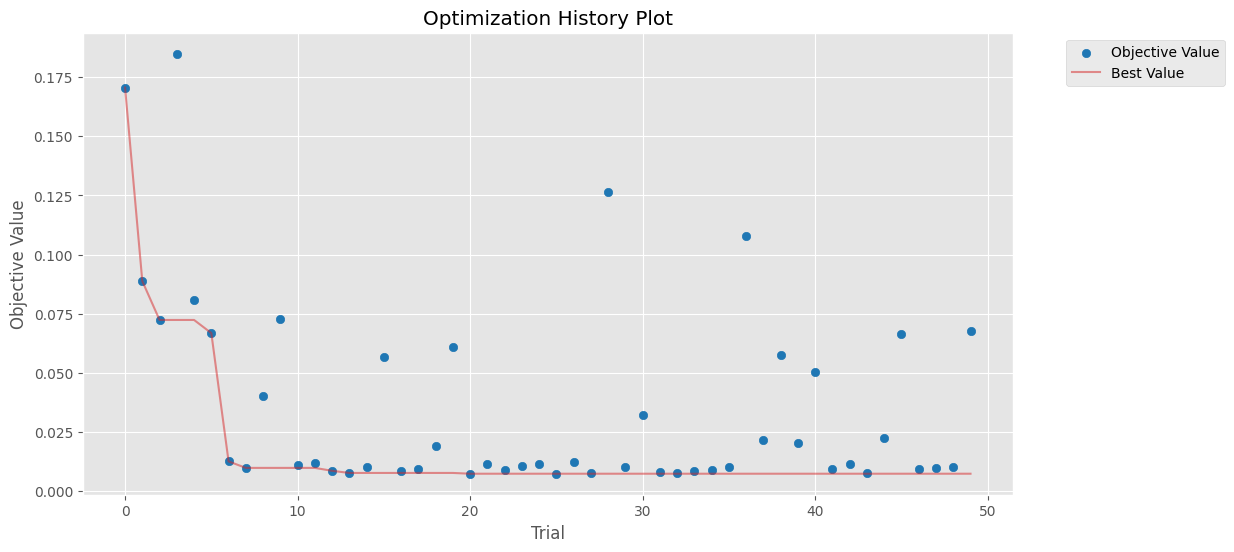

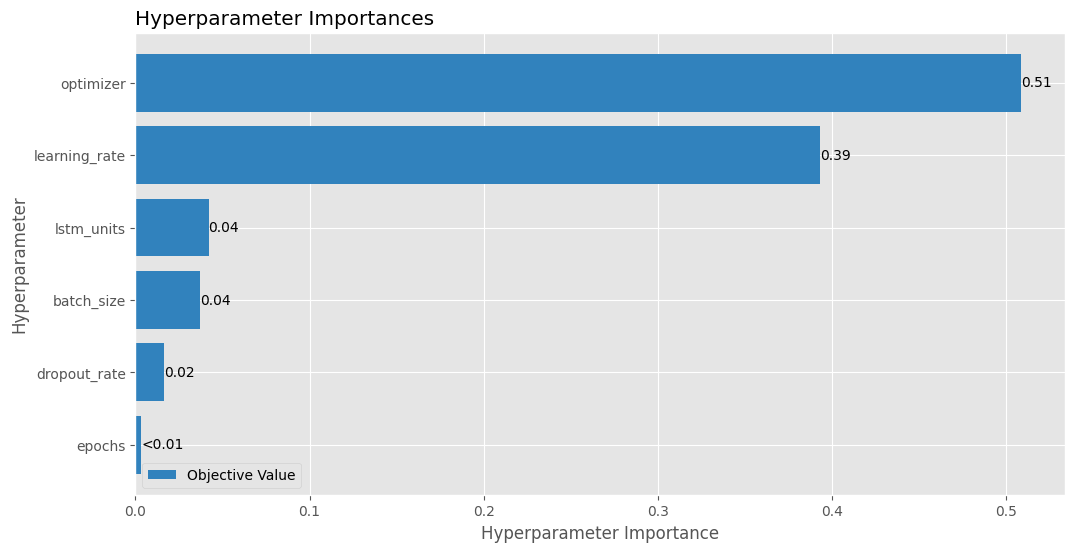

In [22]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [23]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.1662 - val_loss: 0.0032
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0504 - val_loss: 0.0375
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0280 - val_loss: 0.0024
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0237 - val_loss: 0.0248
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0167 - val_loss: 0.0028
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0113 - val_loss: 0.0031
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0036
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077 - val_l

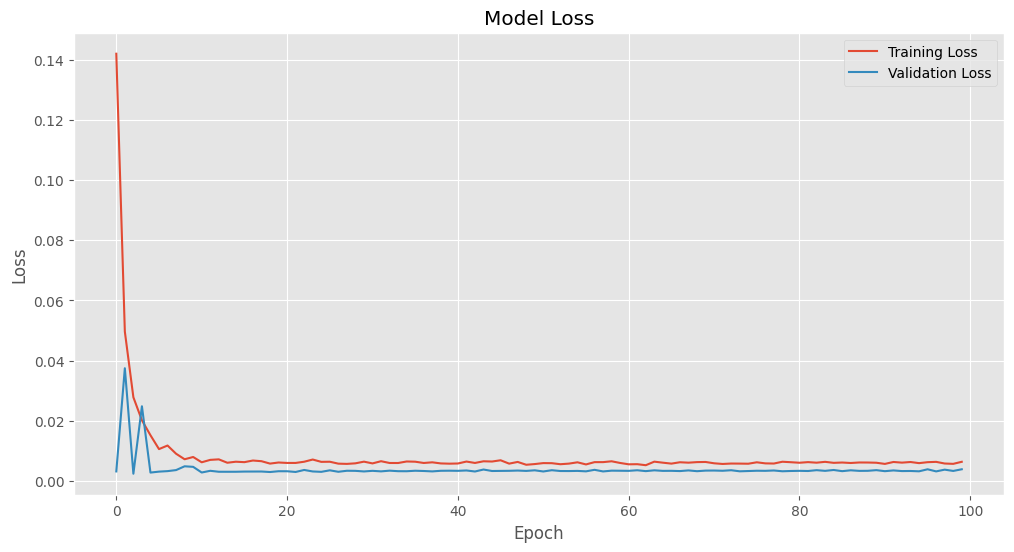

Average Loss: 0.0085


In [24]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [25]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [26]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [28]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 189.171
Root Mean Square Error: 254.318
Mean Absolute Percentage Error: 10.539%

evaluasi model data test:
Mean Absolute Error: 180.013
Root Mean Square Error: 241.882
Mean Absolute Percentage Error: 17.008%



In [29]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

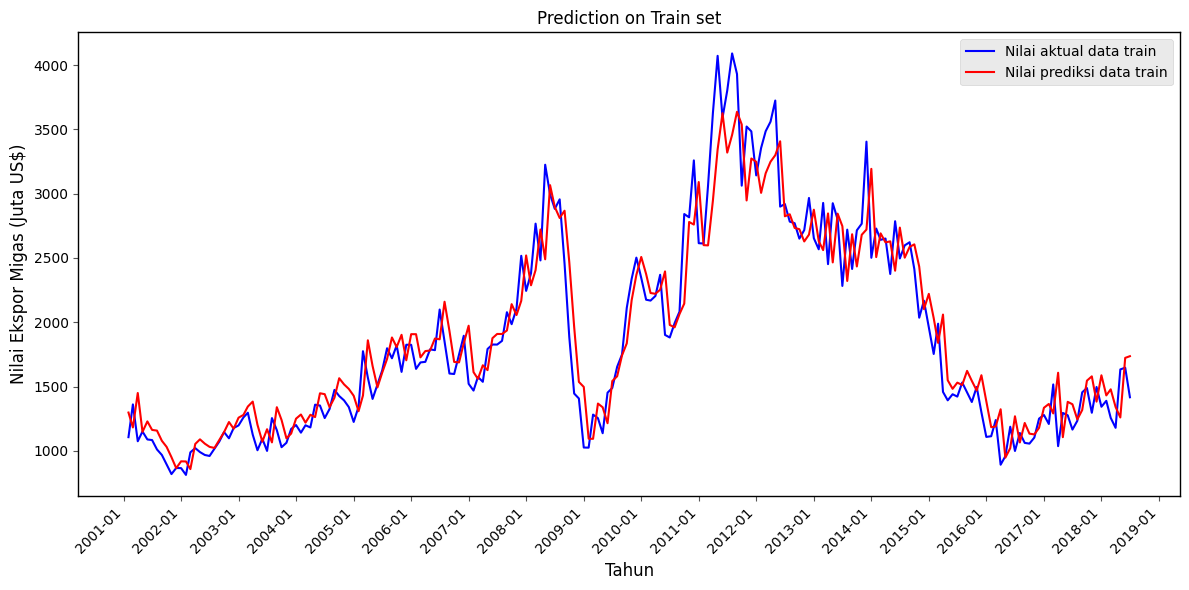

In [30]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

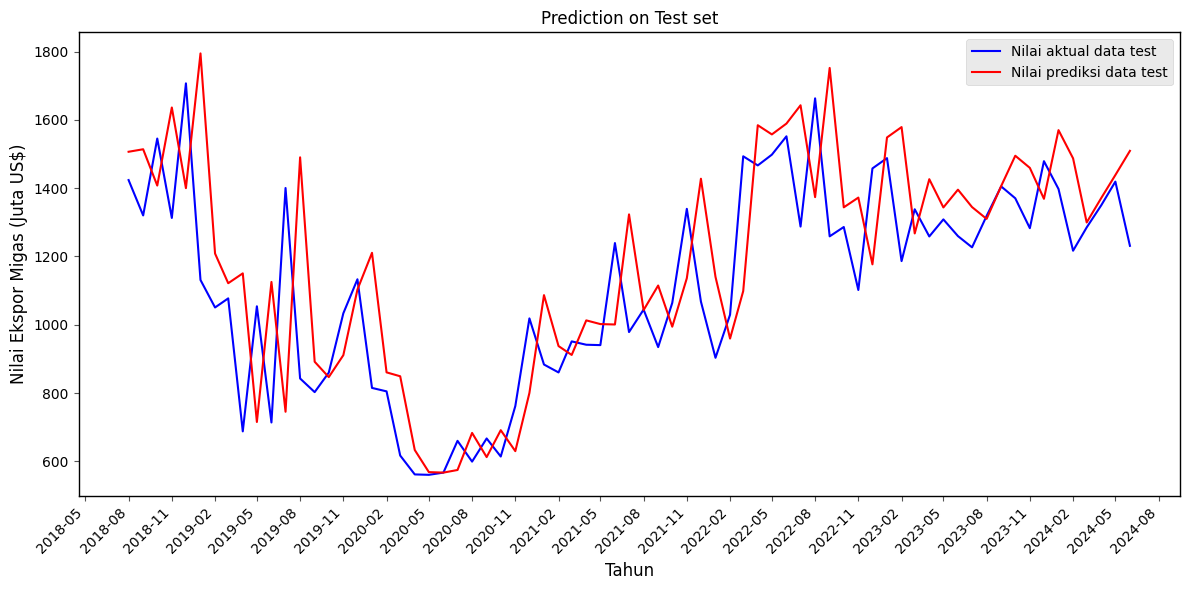

In [31]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

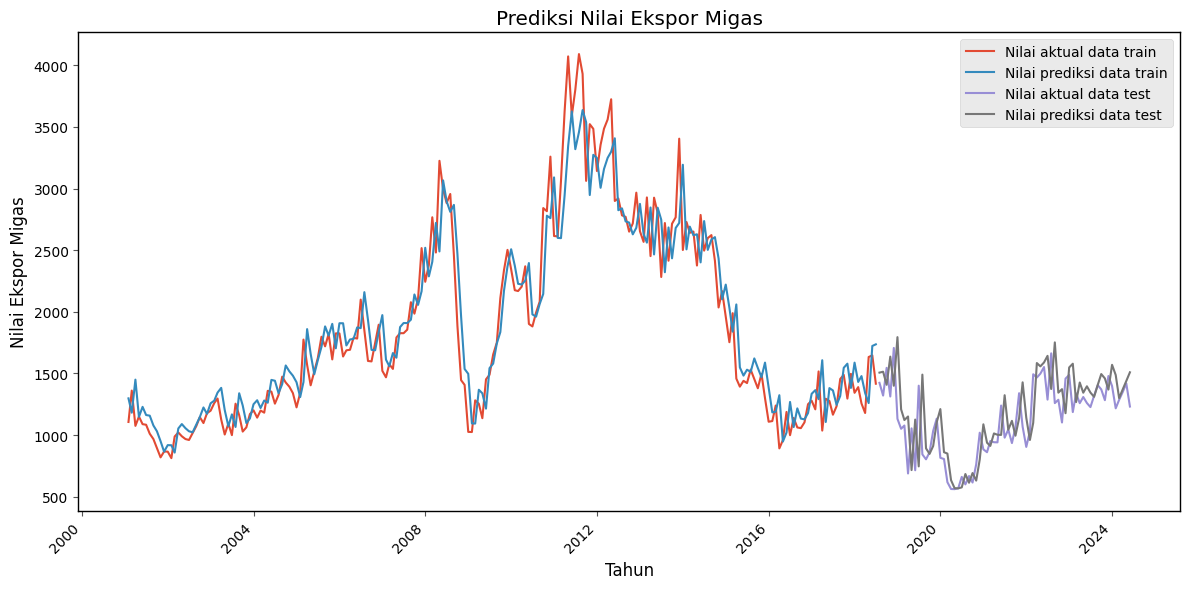

In [32]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-07-01                     1314.710571
1  2024-08-01                     1401.967407
2  2024-09-01                     1491.757568
3  2024-10-01                     1582.689697
4  2024-11-01                     1673.272949
5  2024-12-01                     1762.014404
6  2025-01-01                     1847.517456
7  2025-02-01                     1928.570801
8  2025-03-01                     2004.212646
9  2025-04-01                     2073.767334
10 2025-05-01                     2136

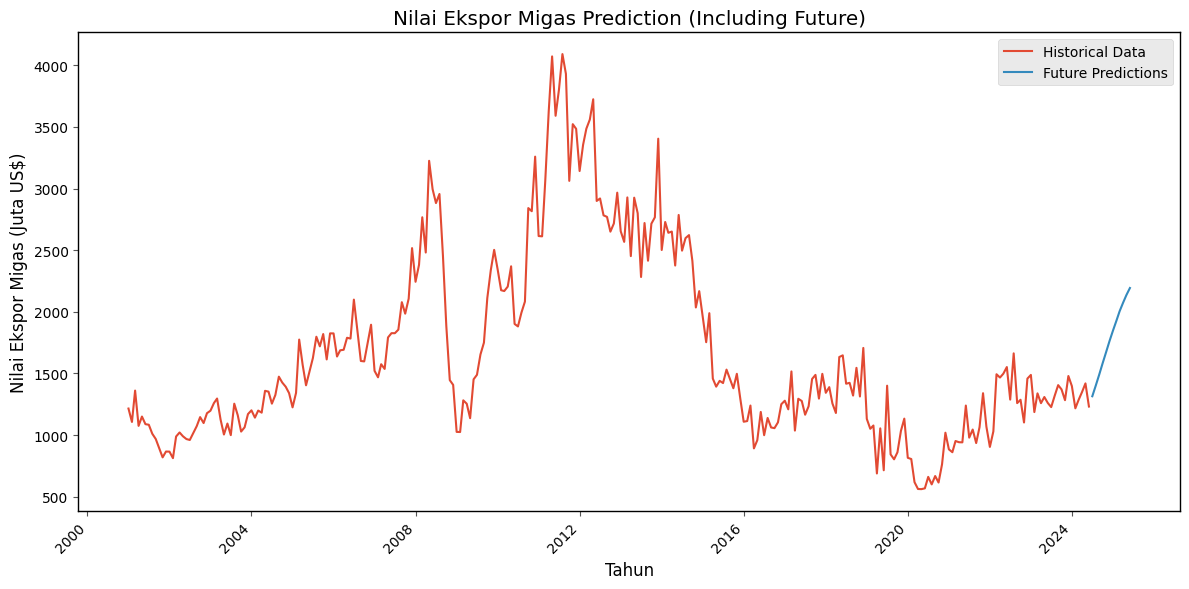

In [33]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


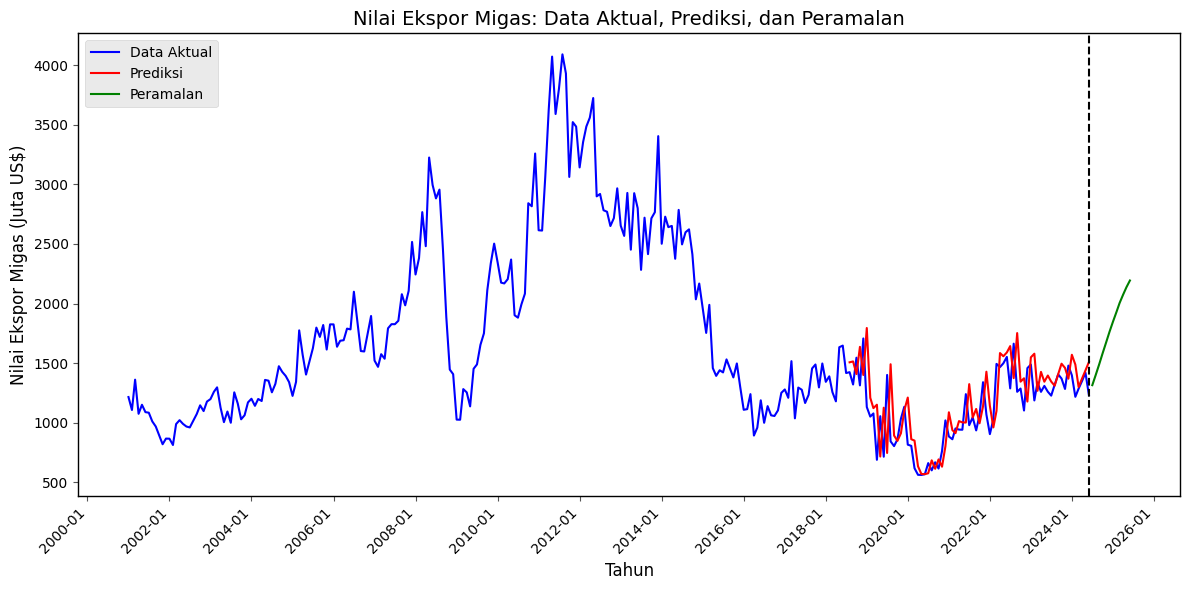

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [35]:
!pip install openpyxl

In [36]:
forecast_df.to_excel('forecast_2024-75:25_h1t1.xlsx', index=False)
from google.colab import files
files.download('forecast_2024-75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_2024-75:25_h1t1.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_2024-75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>